## What is Convolution?

Convolution is a mathematical tool that has been used widely for decades to sort out important or meaningful information from signals.  for example, convolution is a key component to all electronics that we use, from radios to mobile phones, sorting out the interesting part of a message from the background.


Convolution is a special method for combining tensors so that we can find any useful information that may be present.  there are two objects needed for convolution to work: The input signal and the **convolution kernel** or just kernel.  We will see that in the neural network context, the kernel is usually called a **filter**.

Convolution is either *Discrete* or *Continuous*.  We will only be discussing discrete convolution.  The formula for calculating the output $y$ of a one-dimensional discrete convolution is:

$$y[n] = \sum_{k=1}^n(x[n] \cdot h[n-k]),$$

where $n$ is the step, $x[n]$ is the input and $h$ represents the kernel.

We can perform a discrete convolution directly using numpy.  We'll stick with one dimension for a bit.

In [12]:
import numpy as np

x = np.ones((4,), dtype=np.float32) # array of 3 ones
h = np.array([1, 1, 1])
y = np.convolve(x, h, mode='VALID') # this returns a single value.
y

array([ 3.,  3.])

The mode used above tells the convolution whether or not to **zero-pad** the beginning and ending of the output.  without zero padding, as above, $y$ is smaller than $x$.  There are 3 options for the mode:

* SAME - add zeros to the beginning and ending of $x$ so that $y$ is the same shape as $x$.
* VALID - No zeros at the beginning or end of $x$ so the output $y$ is smaller that the input.
* FULL - All points of overlap between $x$ and $h$ are considered, so this is similar to FULL>  We won't use this mode.

'SAME' and 'VALID' sampling are supported in tensorflow convolutions.  Below we do the same convolution as above but with `mode='SAME'`.

In [13]:
y = np.convolve(x, h, mode='SAME') # this returns a single value.
y

array([ 2.,  3.,  3.,  2.])

To imagine what is happenening, lets look at what the calculation is doing here. First, with 'VALID' (no) padding, the first step is:

```
[1, 1, 1]         # h
 |  |  |
 V  V  V
[1, 1, 1, 1]      # x
---------
    3             # y[0]
```

and the second step:

```
   [1, 1, 1]      # h
    |  |  |
    V  V  V
[1, 1, 1, 1]      # x
   ---------
       3          # y[1]
```

Here is the first step with 'SAME' padding:

```
[1, 1, 1]         # h
 |  |  |
 V  V  V
 0 [1, 1, 1, 1]   # x
---------
    2             # y[0]
```

and the second step:

```
   [1, 1, 1]      # h
    |  |  |
    V  V  V
 0 [1, 1, 1, 1]   # x
   ---------
       3          # y[1]
```
And so on.  The padding will also happen on the last step:

```
         [1, 1, 1]      # h
          |  |  |
          V  V  V
 0 [1, 1, 1, 1] 0       # x
         ---------
             2          # y[4]
```

Also, the size of the padding will change based on the size of the kernel.  Longer kernels require more padding for 'SAME' mode.  Note that $y$ has the *same* shape as $x$.

### 2D Convolutions with tensorflow
So far we are looking at rank 1 tensors (i. e., vectors) for the input, the kernel, and the output.  convolutions are often used with higher order tensors to process images.  Convolutions are a foundational tool in image processing and object recognition.

Visualizing convolution can be challenging.  [Vincent Dumoulins github](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has a great gif visualization of 2D convolutios.

In [77]:
# A tensorflow example in higher dimensions
# First, lets load some small MNIST samples from scikit-learn
#from sklearn.datasets import load_digits
#digits = load_digits()

from tensorflow.examples.tutorials.mnist import input_data
digits = input_data.read_data_sets("MNIST_data/", one_hot=False).train

print(digits.images.shape)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)


9
(784,)
(28, 28)


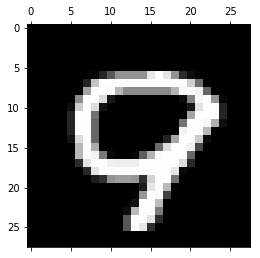

In [84]:
import matplotlib.pyplot as plt 
index = 45
print(digits.labels[index])
inp = digits.images[index]
print(inp.shape)
inp.resize(28, 28)
print(inp.shape)
plt.gray() 
plt.matshow(inp) 
plt.show() 

# prepare tensor
inp.resize(1,28,28,1)

(3, 3)
(3, 3, 1, 1)
(3, 3)


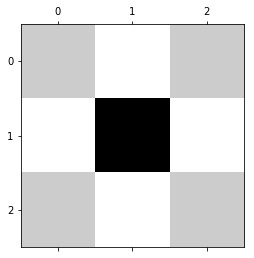

In [85]:
# create a small convolution kernel for edge detection
kernel = np.matrix([[0,  1, 0], 
                    [1, -4, 1], 
                    [0,  1, 0]])
filt = np.copy(kernel)
print(filt.shape)
filt.resize(filt.shape[0], filt.shape[1], 1, 1)
print(filt.shape)
print(kernel.shape)
# we can display the kernel as a 3X3 gray-scale image
plt.gray() 
plt.matshow(kernel) 
plt.show() 

(1, 26, 26, 1)


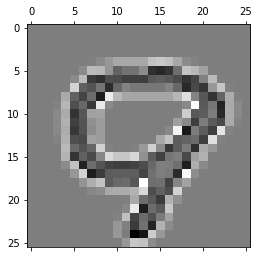

In [87]:
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# now we can define a tensorflow graph that 
#  applies the convolution to the input image.
x = tf.placeholder(tf.float32, shape=None, name = "x")
h = tf.placeholder(tf.float32, shape=None, name = "h")

conv = tf.nn.conv2d(x, h, strides=[1, 1, 1, 1], padding = 'VALID')
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    result = sess.run(conv, feed_dict = 
                      {x: inp, h: filt})
    print(result.shape)
    plt.gray() 
    plt.matshow(result.reshape(26,26)) 
    plt.show()
    
    

Here we have hard-coded a kernel for convolving images and run it through tensorflow to generate a new image.  below we do this again for a zero-padded image:

(1, 28, 28, 1)


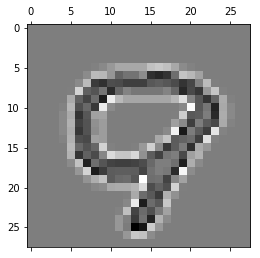

In [90]:
conv2 = tf.nn.conv2d(x, h, strides=[1, 1, 1, 1], padding = 'SAME')
with tf.Session() as sess:
    sess.run(init)
    result = sess.run(conv2, feed_dict = 
                      {x: inp, h: filt})
    print(result.shape)
    plt.gray() 
    plt.matshow(result.reshape(28,28)) 
    plt.show()
    


(1, 28, 28, 1)


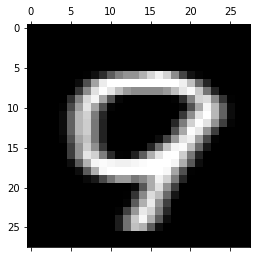

In [93]:
# Try some alternate kernels to see what they do.
horizontal_kernel = np.matrix([[0, 0, 0], 
                               [1, 1, 1], 
                               [0, 0, 0]])
horizontal_kernel.resize(3, 3, 1, 1)
with tf.Session() as sess:
    sess.run(init)
    result = sess.run(conv2, feed_dict = 
                      {x: inp, h: horizontal_kernel})
    print(result.shape)
    plt.gray() 
    plt.matshow(result.reshape(28,28)) 
    plt.show()
    


(1, 28, 28, 7)


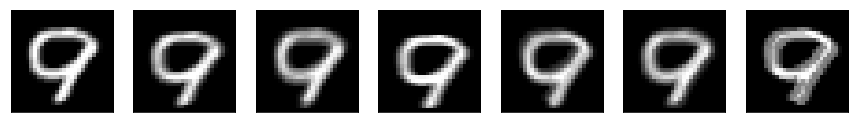

In [121]:
# more than one kernel at a time
kernels = np.array([
           [[0, 0, 0], [1, 1, 1], [0, 0, 0]],
           [[1, 1, 1], [0, 0, 0], [1, 1, 1]],
           [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
           [[1, 0, 1], [1, 0, 1], [1, 0, 1]],
           [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
           [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
           [[1, 0, 1], [0, 1, 0], [1, 0, 1]],
           ], dtype=np.float32)

kernels.resize(3, 3, 1, 7)
with tf.Session() as sess:
    sess.run(init)
    result = sess.run(conv2, feed_dict = 
                      {x: inp, h: kernels})
    print(result.shape)
    
fig, ax = plt.subplots(1, result.shape[3], figsize=(15,15))
for i in range(result.shape[-1]):
    ax[i].matshow(result[:, :, :, i].reshape(28,28), cmap=plt.cm.gray)
    ax[i].set_xticks(())
    ax[i].set_yticks(())

plt.show()
    


### Convolutional Neural Networks
A Convolutional Neural Network (CNN) will learn kernel values and then apply them to input images.  Another notebook will go into this topic.  